ФИО: Усцов Артем Алексеевич

In [36]:
# uncomment to install pmdarima
# !pip install pmdarima

In [43]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
import random
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

In [44]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [45]:
# check if cuda device is available on your device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [48]:
GLOBAL_SEED = 42
global_epoch = 0
global_iter = 0

# Ноутбук для ДЗ №7 обработка временных последовательностей RNN
В данном дз вам будут данных времменая последовательно, которая описывает распределение хитов по времени за несколько лет. Вам нужно будет обучить модель RNN на исторических данных и потом сделать предсказание для "будущего" года, в текущей задаче это 2019 год

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [3]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [4]:
data = pd.read_csv('data/train.csv')
data

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490
...,...,...
1091,2018-12-27,241134980
1092,2018-12-28,234865040
1093,2018-12-29,195884690
1094,2018-12-30,125587958


In [5]:
data_train = read_set('data/train.csv')
data_test =  read_set('data/derived.csv')
data_sample = read_set('data/sample_submission.csv')

In [6]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


### Проверим наши данные, что мы загрузили

In [7]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [8]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [9]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [10]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

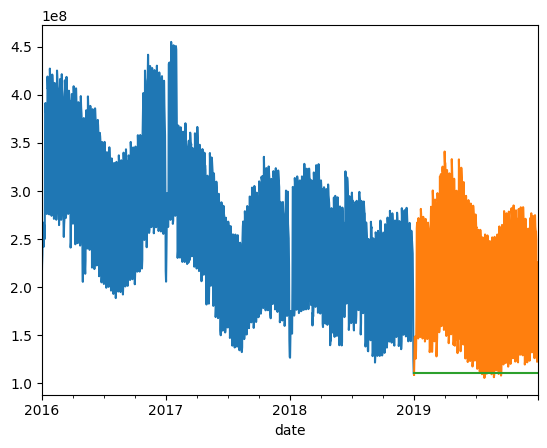

In [11]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_sample['value'].plot(kind = 'line')
plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [12]:
# AutoArima model learning
arima_model=model = pm.auto_arima(
    data_train,
    seasonal=True,
    m=4,
    test='adf',
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True, trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=0.38 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=0.88 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=1.38 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.126, Time=1.10 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=1.85 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=2.01 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=1.64 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=1.27 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.291, Time=3.11 sec
 ARIMA(2,0,3)(2,0,2

In [13]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [14]:
prediction

,0
date,
2019-01-01,2.201827e+08
2019-01-02,2.753599e+08
2019-01-03,2.348511e+08
2019-01-04,1.709350e+08
2019-01-05,2.155571e+08
...,...
2019-12-27,2.757570e+08
2019-12-28,2.744252e+08
2019-12-29,2.735897e+08


In [15]:
prediction = prediction.rename(columns = {0:'value'})

Baseline prediction

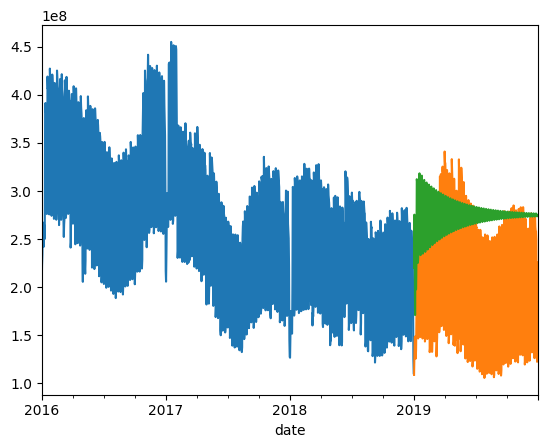

In [16]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line')
plt.show()

### Функция подсчета метрик для конкурса

In [17]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [18]:
MAPE(data_test, prediction)

39.10129621978095

In [19]:
MAPE(data_test, data_sample)

44.81735178659308

## Build dataset from pandas

In [49]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

In [50]:
stats = Stats(data_train)

/Users/a.ustsov/technopark/DL_Homeworks/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [51]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        self._len = len(data) - seq_len + 1 
        self.mean = stats.mean
        self.std = stats.std
        self.data = (data- self.mean) / self.std 
        self.seq_len = seq_len
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len]
        targets = []
        days   = []
        months = []
        year = []
        for row in  d.iterrows():
            targets += [ row[1]['value'] ]
            days += [ row[0].day ]
            months += [row[0].month]
            year += [row[0].year]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(year), \
               torch.FloatTensor(targets)

In [52]:
ds_train = TSDataset(data_train, 20) 
ds_test  = TSDataset(data_test, 20)
print(len(ds_train))

1077


## Теперь нужно определить нашу модель 

In [53]:
seed_everything(GLOBAL_SEED)

In [58]:
class TimeSeriesModel(nn.Module):
        def __init__(self, hidden_size: int, input_sizes: tuple):            
            super().__init__()
            self.mon_emb = nn.Embedding(12+1, input_sizes[0])
            self.day_emb = nn.Embedding(31+1, input_sizes[1])
            self._rnn = nn.LSTM(input_sizes[0] + input_sizes[1] + 1,  hidden_size,  batch_first=True)
            self._output = nn.Linear(hidden_size, 1)
            
        def forward(self, batch, ctx = None):
            days, mons, _, targets = batch
            mon_tensor = self.mon_emb(mons)
            day_tensor = self.day_emb(days)
            rnn_input  = torch.cat([mon_tensor, day_tensor], dim=-1)
            targets = targets.unsqueeze(-1)
            rnn_input = torch.cat([rnn_input, targets ], dim=-1)
            rnn_input = rnn_input[:, :-1, :] if ctx is None else rnn_input
            output, ctx = self._rnn(rnn_input, ctx)
            output = self._output(output).squeeze()
            return output, ctx    
        
        def _incremental_forward(self, rnn_input, prev_value: torch.FloatTensor, ctx):
            T = rnn.input.shape[1]
            cur_input = rnn_input[:, :1, :]
            cur_ctx = rnn_input[:, :1, :]
            cur_ctx = ctx
            rnn_output = []
            for t in range(T):
                cur_input = torch.cat([cur_input, prev_value], dim=-1)
                prev_value, cur_ctx = self._rnn(cur_input)
                prev_value = self._output(prev_value)
                rnn_output += [prev_value]
            output = torch.cat(rnn_output, dim=1)
            return output.squeeze(), cur_ctx

### Определяем даталоадеры для теста и трейна

In [59]:
dl_train = DataLoader(ds_train, 8, True)
dl_test = DataLoader(ds_test, 8, False)

In [60]:
series_model = TimeSeriesModel(32, (4,4))

In [61]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=5e-4)

In [62]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./logs/rnn_hw')

### Обучаем модель

In [63]:
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    return sum_loss

In [64]:
# модель обучаем в режиме teacher forcing, т.е. на вход подаем сразу всю последовательность,
# на выходе таргет должен быть смещен на один временной шаг, чтобы правильно считался лосс

for epoch in range(0, 100):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:,1:]
        result, _ = series_model(batch)        
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 123.24it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 140.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 144.93it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 122.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 113.31it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 129.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 116.42it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 125.07it/s]


In [66]:
# сохраняем модель
torch.save(series_model.state_dict(), 'series_model.ptx')

In [67]:
# восстанавливаем модель
series_model = TimeSeriesModel(32, (4,4))
series_model.load_state_dict(torch.load('series_model.ptx'))

<All keys matched successfully>

### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.

In [68]:
train_last_window = DataLoader(ds_train, 1, False)
last_window = None
for b in train_last_window:
    last_window = b

In [69]:
last_window

[tensor([[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
          30, 31]]),
 tensor([[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
          12, 12]]),
 tensor([[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,
          2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018]]),
 tensor([[-0.1291, -0.1936, -0.4293, -1.7672, -1.7341, -0.2415, -0.3038, -0.1620,
          -0.2428, -0.5024, -1.7640, -1.7625, -0.2683, -0.4030, -0.4092, -0.4963,
          -0.5780, -1.0860, -2.0020, -2.2004]])]

In [71]:
with open('my_submission.csv', 'wt') as sf:
    print('date, hits', file=sf)
    with torch.no_grad():
        series_model.eval()
        ds_val = TSDataset(data_test, 1)
        output, ctx = series_model(last_window)
        d, m, year, prev = last_window[0][0, -1:], last_window[1][0, -1:], last_window[2][0, -1:], output[-1:]
        print(d, m, year)
        result = []
        for i in range(len(ds_val)):
            output, ctx = series_model((d.unsqueeze(0), m.unsqueeze(0), 0, prev.unsqueeze(0)), ctx)
            result += [float(output)]
            t = ds_val[i]
            d, m, year, prev = t[0], t[1], t[2], torch.FloatTensor([output])
            print('%d-%02d-%02d, %d' %(year, m, d, float(prev) * stats.std + stats.mean), file=sf)

tensor([31]) tensor([12]) tensor([2018])


In [73]:
data_nn_submission = read_set('my_submission.csv')
MAPE(data_test, data_nn_submission)

30.77994851803698

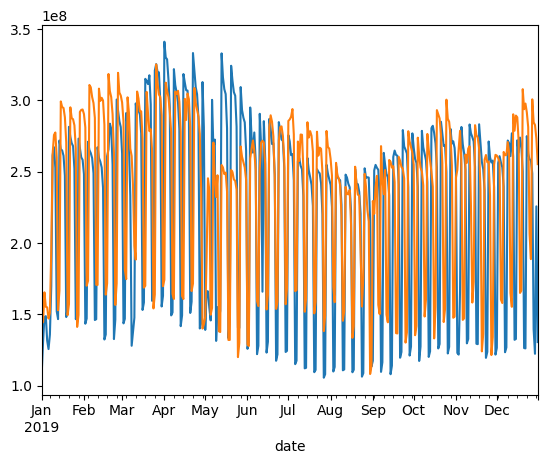

In [76]:
plt.figure()
# data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
# plt.plot(data_forecasted, label = "Prediction")
data_nn_submission['value'].plot(kind = 'line')
plt.show()